## learning-AI : rehab
### weather dataset로 Deep Convnet using Residual Conn, LSTM-DNN

<br>

- **임규연 (lky473736)**
- 2025.07.29.에 문서 작성

- **Keyword** : Regression, LSTM, Time-series data processing


<br>
<div style="text-align : center"><h3>- abstract - </h3></div>

```
This study analyzes the Jena Climate dataset to perform temperature forecasting using multivariate time series data. After preprocessing steps including handling missing values, normalization, and feature exploration, the data is structured using a sliding window approach. LSTM and GRU models are then applied for single-step prediction of air temperature based on the past 24 hours of observations. Model performance is evaluated using the R² score, and training loss is monitored across epochs. Results indicate that both recurrent models effectively capture temporal patterns in the weather data.
```
<br>

-------

### <mark>1. introduction</mark>

본 실험에서는 시계열 데이터셋인 Weather 데이터셋에 대한 LSTM 회귀를 수행한다. 이 데이터셋은 독일 예나(Jena) 지역의 2009~2016년까지의 기상 데이터를 포함하고 있다. 총 420,551개의 시간 단위 데이터가 있으며, 다양한 기상 요소가 측정되었다.

- **관측 지역**: 독일 예나 (Jena, Germany)
- **관측 주기**: 10분 간격, 약 420,000개 이상 데이터
- **관측 기간**: 2009년 ~ 2016년
- **타겟 변수**: `T (degC)` (섭씨 온도)
- **예측 목적**: 과거의 기후 데이터를 기반으로 미래의 온도 예측
- **활용 모델**: LSTM, GRU

아래는 각 Feature에 대한 설명이다.

| Feature 이름        | 설명                                  |
|---------------------|----------------------------------------|
| `Date Time`         | 날짜 및 시간                           |
| `p (mbar)`          | 기압 (mbar)                            |
| `T (degC)`          | 온도 (섭씨)                            |
| `Tpot (K)`          | Potential temperature (Kelvin)         |
| `Tdew (degC)`       | 이슬점 온도 (섭씨)                     |
| `rh (%)`            | 상대 습도 (%)                          |
| `VPmax (mbar)`      | 최대 수증기압                          |
| `VPact (mbar)`      | 실제 수증기압                          |
| `VPdef (mbar)`      | 증기압 결핍                             |
| `sh (g/kg)`         | 특이 습도 (g/kg)                       |
| `H2OC (mmol/mol)`   | 수분 농도                              |
| `rho (g/m**3)`      | 공기 밀도                              |
| `wv (m/s)`          | 풍속 (m/s)                             |
| `max. wv (m/s)`     | 최대 풍속 (m/s)                        |
| `wd (deg)`          | 풍향 (도 단위)                         |

우리는 이 중에서 `T (degC)`를 target으로 삼아 예측하고자 한다.

본 LSTM 모델을 구현할 테크는 아래와 같다.

- **데이터 읽기 및 전처리 테크닉** : pandas
- **모델링 및 머신러닝-딥러닝 라이브러리** : scikit-learn, TensorFlow, Keras
- **선형대수학 및 tensor 이용** : numpy
- **데이터 시각화** : matplotlib, seaborn

데이터 분석은 아래와 같은 단계로 진행된다.

- **1) 데이터 구조 파악 및 전처리, 시각화**
    - 데이터의 구조 및 기초 통계량 확인, 특정 attribute에 대한 간단한 시각화를 진행한다.
- **2) GRU 기반의 regression 진행 및 성능 지표 출력, 시각화**

In [9]:
!pip install torchinfo

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np
import torch
from torch import nn, optim
from torchinfo import summary
import keras

-----------

### <mark>2. 데이터 구조 파악 및 전처리, 시각화 </mark>
- 본 단계에서는 데이터의 기초적인 통계량 파악, 데이터 전처리 및 각 attribute에 대한 시각화를 진행한다.

In [11]:
# numpy로 데이터를 읽는다

from zipfile import ZipFile

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "/content/jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [12]:
# 기본 정보 및 자료형
print(df.info())
print("\nShape:", df.shape)

# 기초 통계 확인
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB
None

Shape: (420551, 15)


,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


위 기초통계량을 확인하였을 때 다음과 같은 사실을 유추 가능하다.

- **기온 관련 변수**
  - `T (degC)`는 평균 약 **9.45도**로, **최소 -23.01도에서 최대 37.28도**까지 분포하고 있다. 이는 독일 예나 지역의 연중 온도 범위를 잘 반영한다.
  - `Tdew (degC)`는 이슬점 온도로, 평균 약 **4.96도**이며 `T (degC)`보다 낮은 경향을 보인다.
  - `Tpot (K)`는 potential temperature로, 평균 **약 283.49K(섭씨 약 10.3도)** 로 나타난다.

- **기압 관련 변수**
  - `p (mbar)`는 평균 약 **989.2 mbar**로, 해수면 기준보다 약간 낮으며, **최소 913.6에서 최대 1015.35** 까지 존재한다.
  - 이는 고도나 기상 상태에 따라 변하는 대기압의 자연스러운 분포를 보여준다.

- **수증기 및 습도 관련**
  - `rh (%)`는 상대 습도로, 평균 약 **76%** 로 상당히 높은 습도를 나타낸다.
  - `VPmax`, `VPact`, `VPdef`는 수증기 포화/실제/차이 압력으로, 이들 간의 관계는 증기 포화 상태에서의 기상 변화 정도를 나타낸다.
  - `sh (g/kg)`와 `H2OC (mmol/mol)`는 수증기량 지표이며 평균적으로 각각 **6.02 g/kg**, **9.64 mmol/mol** 정도로 기록된다.

- **풍속 관련 변수**
  - `wv (m/s)`와 `max. wv (m/s)`는 각각 평균 풍속과 최대 순간 풍속을 의미하며, 평균 값은 각각 **1.70 m/s**, **3.06 m/s**이다.
  - 하지만 최소값이 `-9999.0`으로 기록되어 있는 것을 통해, **센서 오류 또는 결측치 표시 값이 존재함을 알 수 있다.** 추후 전처리 필요성이 있다.
  - `wd (deg)`는 풍향을 나타내며, **0 ~ 360도 범위로 고르게 분포** 하고 있다.

위 사실을 바탕으로 전처리 시 주의할 점을 정리하였다.

- 변수 간 단위가 서로 다르기 때문에 **스케일링이 필수** 적이다. 이는 MinMax Scaling으로 해결한다.
- 풍속 관련 변수에 **센서 오류값(-9999.0)** 이 존재하여 **전처리 시 제거 또는 대체 필요** 가 있다.
- 모든 변수는 수치형이며, 결측치가 거의 없어 **결측처리 후 바로 시계열 분석 가능** 하다.

In [13]:
# -9999.0 이상치를 NaN으로 바꾼 후 보간 처리 진행함
df.replace(-9999.0, pd.NA, inplace=True)
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)

# 결측치 확인
print(df.isna().sum())

/tmp/ipython-input-13-1904747638.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-13-1904747638.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-13-1904747638.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64


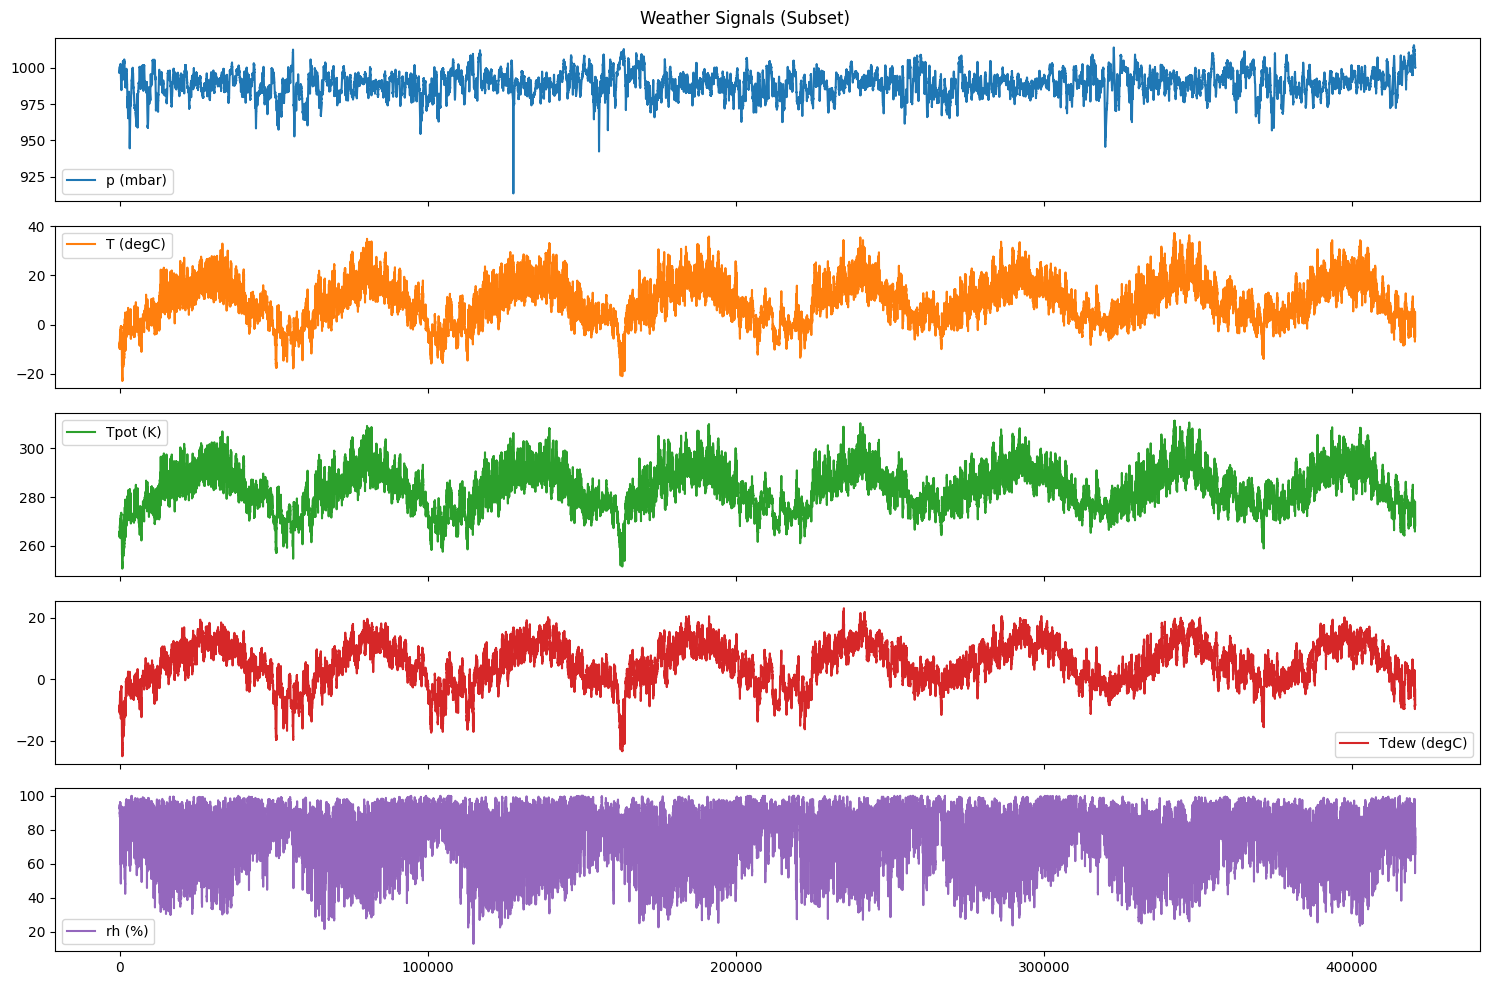

In [14]:
# feature 간 시각화 진행

df.iloc[:, 1:6].plot(subplots=True, figsize=(15, 10), title="Weather Signals (Subset)")
plt.tight_layout()
plt.show()

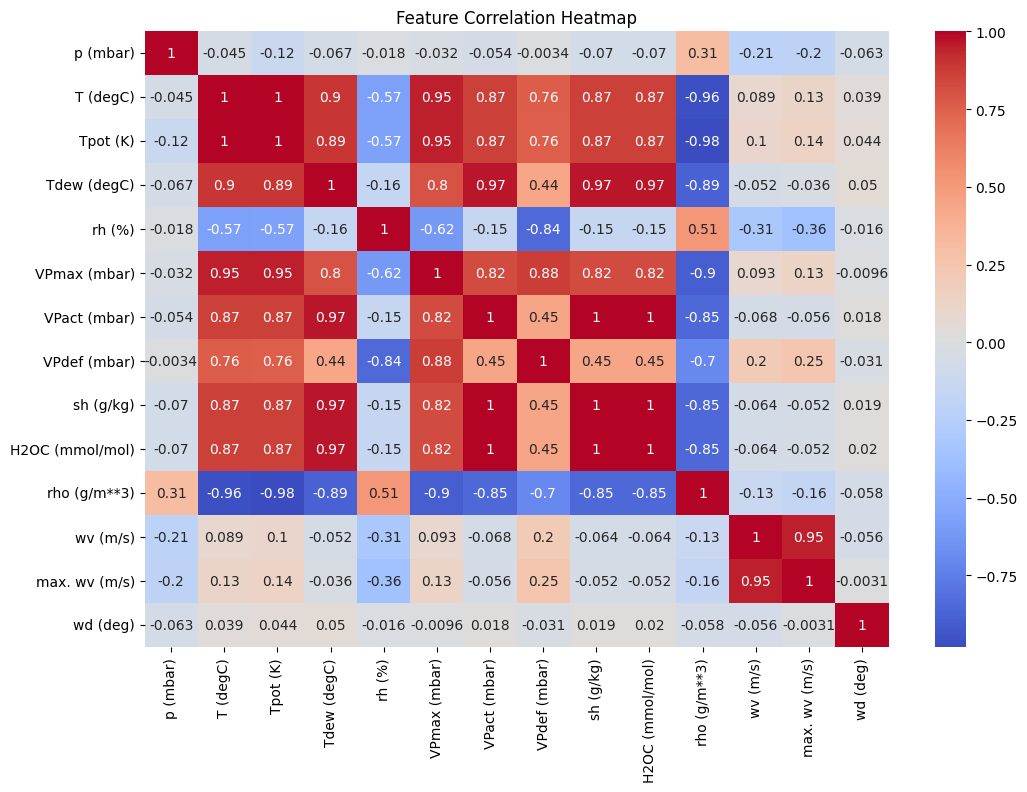

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=True)
plt.title("Feature Correlation Heatmap") # Heatmap
plt.show()

위 heatmap는 음수로 갈 수록 음의 상관관계(반비례), 양수로 갈 수록 양의 상관관계(정비례)를 의미한다. 또한 diagonal을 중심으로 각 part가 대칭이다. (symmetric) figure를 보고 주목해야 할 부분은 아래와 같이 분석할 수 있다.

- **target 변수인 T와 양의 상관관계를 띄는 feature**
    - Tpot (K) (상관계수: 0.90)
        - 퍼텐셜 온도는 실제 온도를 기준으로 계산되므로 기온과 매우 밀접하게 움직인다.

    - VPact (mbar) (상관계수: 0.87)
        - 실제 수증기 압력은 기온이 높을수록 수증기가 많아지기 때문에 함께 증가하는 경향이 있다.

    - sh (g/kg) (상관계수: 0.87)
        - 비중 습도는 공기 중 수분의 질량을 나타내며, 온도가 높을수록 포화수증기량이 증가하므로 같이 증가한다.

    - H2OC (mmol/mol) (상관계수: 0.87)
        - 수분 농도 역시 온도 상승 시 대기 중에 포함될 수 있는 수분이 많아지기 때문에 양의 상관관계를 가진다.

    - VPmax (mbar) (상관계수: 0.76)
        - 증기의 최대 포텐셜은 온도에 의해 결정되므로 기온과 밀접한 관계를 가진다.

    - Tdew (degC) (상관계수: 0.89)
        - 이슬점 온도는 공기 중 수분의 포화 상태와 관련 있고, 일반적으로 기온이 높을수록 이슬점도 높다.
        
**본래 curse of dimensionality를 막기 위해서 feature selection을 수행할 시에는 위 정보가 매우 중요하다.** 상관관계는 즉 어떤 feature가 얼마나 target 데이터와 연관이 있어 데이터 표현을 잘 나타내어 모델에게 인식하게 할 것인가를 결정하기 때문이다. 하지만 본 주피터 노트북에서는 모든 feature을 사용할 것이기 때문에 상관 없겠다.

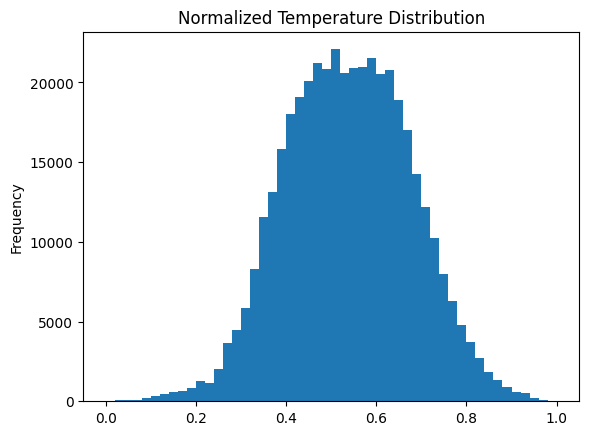

In [16]:
# min max scaling 수행

from sklearn.preprocessing import MinMaxScaler

features = df.drop(columns=["Date Time"]) # Date time은 필요 없으니 drop함
target = features["T (degC)"]
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

scaled["T (degC)"].plot(kind='hist', bins=50, title='Normalized Temperature Distribution')
plt.show()

In [17]:
# split_sequences 함수 정의

def split_sequences(sequences, n_past, n_future):
    X, y = [], []
    for i in range(len(sequences) - n_past - n_future):
        seq_x = sequences[i:i+n_past]
        seq_y = sequences[i+n_past+n_future-1, 1]  # T (degC)
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

"""
- n_past: 입력 시퀀스 길이 (예: 과거 24시간)
- n_future: 예측 간격 (예: 1시간 후)
- X: 3차원 (샘플, 타임스텝, 피처 수), y: 1차원 벡터
"""


'\n- n_past: 입력 시퀀스 길이 (예: 과거 24시간)\n- n_future: 예측 간격 (예: 1시간 후)\n- X: 3차원 (샘플, 타임스텝, 피처 수), y: 1차원 벡터\n'

<img src="https://velog.velcdn.com/images/wlwl99/post/e0ebddc2-e075-41e5-bec6-ac424364d1da/image.png" width=400px>

위 함수는 **sliding window 방식으로 구성** 되었다. sliding window란 투 포인터 풀이 기법에서 많이 쓰이는 테크닉으로, 마치 위 figure의 방식과 같이 좌우로 미끌어지면서 원소를 택하는 방법이다. 여기서 **window는 위 figure에서 원소 4개를 감싸는 박스** 를 의미하며, window의 사이즈는 4개가 된다.

위 함수에서 **len(sequences)는 df의 records의 수 (행의 수)를 의미** 한다. 그니깐 행의 수만큼 반복문을 돌리겠다는 거고, 여기서 i는 행의 위치가 된다. end_ix는 현재 행의 위치와 n_steps를 더한 값으로 구성되고, 여기서 n_steps가 바로 window의 수이다. 1차원적으로 생각해보면, i는 위 figure에서 window의 첫번째 원소를 가리키는 index를 의미하고, n_steps를 i와 더하여 window의 마지막 원소를 가리키는 index를 end_ix라고 선언해 둔 것이다.

end_ix가 전체 데이터프레임의 행의 갯수를 넘어가면 함수가 종료되며, 그 전까지 함수를 진행하는데, seq_x와 seq_y에 각각 순환 데이터를 구성한 input, target을 집어 넣는다. sequences[i+end_ix, :-1]은 i열부터 end_ix - 1행까지, 가장 마지막 열인 target 열을 제외하고 split한 input 데이터를 의미하며, sequences[end_ix-1, -1]은 end_ix - 1행의 마지막 열인 target 열의 값을 target 데이터로 지정해둔 것이다. 여기서 알 수 있는 것은, **기존 split_sequences 함수는 각 window의 마지막 target 값을 순환 데이터의 target값으로 만든다는 사실** 이다. 위 경우에서 **'특정 window에서 마지막 레코드의 target 값을 선택'** 하는 경우이다.

In [18]:
# split_seqeunce를 적용 및 X, y 생성 및 train/val/test 분리

n_past = 144  # 10분 단위 * 144 = 하루
n_future = 1

data = scaled.values
X, y = split_sequences(data, n_past, n_future)

train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.2)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print (X_train.shape, X_val.shape, X_test.shape)

(294284, 144, 14) (84081, 144, 14) (42041, 144, 14)


In [19]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y=None, model_type="resnet"):
        self.X = torch.tensor(X, dtype=torch.float32)

        if y is not None:
            self.y = torch.tensor(y, dtype=torch.float32)
        else:
            self.y = None

        self.model_type = model_type
        if model_type.lower() == "resnet":
            self.X = self.X.permute(0, 2, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

----

### <mark>3. DeepConvnet + Residual Conn, LSTM 기반의 Regression 진행 및 성능 지표 출력, 시각화</mark>

<img src="https://blog.kakaocdn.net/dna/DexjQ/btq38lAARdU/AAAAAAAAAAAAAAAAAAAAANYs2BESfvjjz--ai5TxMIkZ1wEpRSgODWXhQdiGF6xa/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1753973999&allow_ip=&allow_referer=&signature=Chiyz1kSHlY6vr66kiHddIgnrD8%3D" width=400px>

**ResNet**은 Conv를 Residual Connection을 이용하여 매우 길게 쌓은 네트워크로, Overfitting을 막고 이전 것을 다시 불러와 본 입력에 반영할 수 있어 gradient vanishing problem을 해결한다.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/640px-Recurrent_neural_network_unfold.svg.png" width=400px>

**LSTM (Long Short-Term Memory)** 은 순환 신경망(RNN)의 일종으로, 시계열 데이터와 같이 시간에 따른 연속성을 가지는 데이터를 효과적으로 학습하기 위한 딥러닝 모델이다. RNN은 이전 상태의 정보를 현재 상태에 반영함으로써 순차적인 데이터에 적합한 구조이지만, 일반 RNN은 긴 시퀀스를 학습할 때 **기울기 소실(Vanishing Gradient)** 문제로 인해 장기 의존성(long-term dependency)을 잘 기억하지 못하는 한계가 있다.

이 문제를 해결하기 위해 LSTM은 내부에 **셀 상태(Cell State)** 를 도입하고, 이를 조절하는 **입력 게이트(Input Gate), 망각 게이트(Forget Gate), 출력 게이트(Output Gate)** 를 포함하여 정보의 흐름을 조절한다. 이러한 구조 덕분에 **장기적인 정보도 손실 없이 기억하고 사용할 수 있는 능력**을 가지게 된다.


<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width=600px>

시계열 데이터에 LSTM을 사용하는 이유는 다음과 같다.

* **시간적 순서를 유지한 채 학습**할 수 있다.
  → 시계열 데이터는 시간에 따라 변화하는 패턴을 가지므로, 이를 무시하면 정확한 예측이 어렵다.

* **장기적인 시점의 정보까지 활용 가능**하다.
  → 예를 들어 온도 예측 문제에서, 몇 시간 전의 이상치나 패턴이 미래 예측에 중요할 수 있는데, LSTM은 이를 반영할 수 있다.

* **특정 시점의 입력뿐만 아니라 전체 시퀀스의 맥락**을 반영한 예측이 가능하다.
  → 이는 CNN과는 차별화되는 특성으로, CNN은 국소적인 패턴에 초점을 맞추지만 LSTM은 **전체 시퀀스의 의미**를 파악한다.

In [20]:
# Residual Conn 기반의 Deep Convnet 모델 구성

import torch
import torch.nn as nn

class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1) \
                        if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += shortcut
        out = self.relu(out)
        return out

class ResNet1D_Regression(nn.Module):
    def __init__(self, input_channels=14):
        super().__init__()
        self.block1 = ResidualBlock1D(input_channels, 64)
        self.block2 = ResidualBlock1D(64, 64)
        self.block3 = ResidualBlock1D(64, 128)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, 1)  # 회귀 → 출력 1

    def forward(self, x):
        # 입력: (batch, channels=14, seq_len=144)
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.pool(out).squeeze(-1)
        out = self.fc(out)
        return out

resnet = ResNet1D_Regression(input_channels=14).to('cuda')
summary(resnet, input_size=(32, 14, 144))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet1D_Regression                      [32, 1]                   --
├─ResidualBlock1D: 1-1                   [32, 64, 144]             --
│    └─Conv1d: 2-1                       [32, 64, 144]             960
│    └─Conv1d: 2-2                       [32, 64, 144]             2,752
│    └─BatchNorm1d: 2-3                  [32, 64, 144]             128
│    └─ReLU: 2-4                         [32, 64, 144]             --
│    └─Conv1d: 2-5                       [32, 64, 144]             12,352
│    └─BatchNorm1d: 2-6                  [32, 64, 144]             128
│    └─ReLU: 2-7                         [32, 64, 144]             --
├─ResidualBlock1D: 1-2                   [32, 64, 144]             --
│    └─Identity: 2-8                     [32, 64, 144]             --
│    └─Conv1d: 2-9                       [32, 64, 144]             12,352
│    └─BatchNorm1d: 2-10                 [32, 64, 144]             128


In [22]:
# LSTM 모델 구성

class LSTM_Regression(nn.Module):
    def __init__(self, input_dim=14, hidden_dim=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # 회귀 → 출력 1

    def forward(self, x):
        # 입력: (batch, seq_len=144, features=14)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # 마지막 타임스텝
        out = self.fc(out)
        return out

LSTM = LSTM_Regression(input_dim=14, hidden_dim=64).to('cuda')
summary(LSTM, (32, 144, 14))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_Regression                          [32, 1]                   --
├─LSTM: 1-1                              [32, 144, 64]             53,760
├─Linear: 1-2                            [32, 1]                   65
Total params: 53,825
Trainable params: 53,825
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 247.73
Input size (MB): 0.26
Forward/backward pass size (MB): 2.36
Params size (MB): 0.22
Estimated Total Size (MB): 2.83

resnet


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

epoch 1 : train loss 0.02046756169091308, val loss 0.01600000415116249
epoch 2 : train loss 0.02073057069659567, val loss 0.015478466548641684
epoch 3 : train loss 0.02066870164452227, val loss 0.01537404210430956
epoch 4 : train loss 0.020645453523487223, val loss 0.015306549233757263
epoch 5 : train loss 0.02062940815119568, val loss 0.015321418183663896
epoch 6 : train loss 0.020627945114264943, val loss 0.01528811877061462
epoch 7 : train loss 0.02062177598907591, val loss 0.015431163777724865
epoch 8 : train loss 0.02061870687537813, val loss 0.015249088048443729
epoch 9 : train loss 0.020614296174549945, val loss 0.015243506477185385
epoch 10 : train loss 0.02060838263573803, val loss 0.015345191073037704


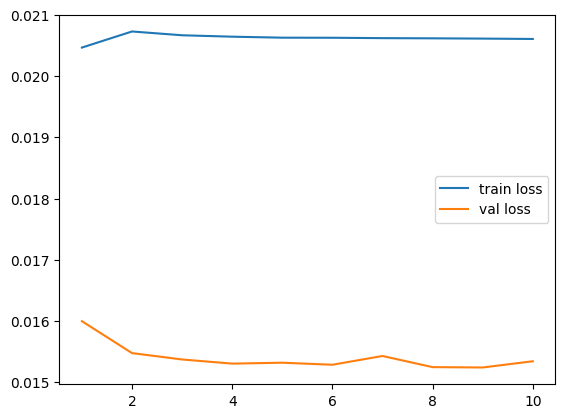

/tmp/ipython-input-23-1830321337.py:97: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(y_hat, y_batch, reduction='sum')
/tmp/ipython-input-23-1830321337.py:97: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(y_hat, y_batch, reduction='sum')


Test MSE: 0.5825
R² Score: -47336.0273
LSTM-DNN
epoch 1 : train loss 0.021059052142150262, val loss 0.015464126749683631


RuntimeError: cudnn RNN backward can only be called in training mode

In [23]:
# 모델 학습 (hyperparameter 정의 -> 학습 -> 테스트 및 성능 지표 확인)

for i, model in enumerate([resnet, LSTM]) :
    train_dataset, val_dataset, test_dataset, train_DL, val_DL, test_DL = 0, 0, 0, 0, 0, 0
    if i == 0 :
        print ("resnet")

        train_dataset = TimeSeriesDataset(X_train, y_train, model_type="resnet")
        val_dataset   = TimeSeriesDataset(X_val, y_val, model_type="resnet")
        test_dataset  = TimeSeriesDataset(X_test, y_test, model_type="resnet")


    else :
        print ("LSTM-DNN")

        train_dataset = TimeSeriesDataset(X_train, y_train, model_type="LSTM")
        val_dataset   = TimeSeriesDataset(X_val, y_val, model_type="LSTM")
        test_dataset  = TimeSeriesDataset(X_test, y_test, model_type="LSTM")


    train_DL = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_DL = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_DL = DataLoader(test_dataset, batch_size=32, shuffle=False)

    optimizer = optim.AdamW(model.parameters(),
                           lr=0.001)
    epoch = 10
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    model.train()
    for ep in range (epoch) :
        train_loss = 0
        val_loss = 0

        for X_batch, y_batch in train_DL :
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')

            # inference
            y_hat = model.forward(X_batch)

            # loss
            loss = criterion(y_hat, y_batch)

            # deriviate
            optimizer.zero_grad()
            loss.backward()

            # update
            optimizer.step()

            train_loss += loss.item()

        # validation
        model.eval()
        with torch.no_grad() :
            for X_batch, y_batch in val_DL :
                X_batch = X_batch.to('cuda')
                y_batch = y_batch.to('cuda')

                # inference
                y_hat = model.forward(X_batch)

                # loss
                loss = criterion (y_hat, y_batch)

                val_loss += loss.item()

        train_losses.append(train_loss / len(train_DL))
        val_losses.append (val_loss/len(val_DL))
        print (f"epoch {ep+1} : train loss {train_losses[-1]}, val loss {val_losses[-1]}")

    # figure about loss per epoch
    plt.plot([ep for ep in range (1, epoch+1)], train_losses, label="train loss")
    plt.plot([ep for ep in range (1, epoch+1)], val_losses, label="val loss")
    plt.legend()
    plt.show()

    # MSE checking, R^2 checking

    import torch.nn.functional as F

    test_MSE = 0.0
    y_true = []
    y_pred = []

    model.eval()

    with torch.no_grad():
        for X_batch, y_batch in test_DL:
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')
            y_hat = model(X_batch)
            mse = F.mse_loss(y_hat, y_batch, reduction='sum')
            test_MSE += mse.item()
            y_true.append(y_batch)
            y_pred.append(y_hat)

    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)

    test_MSE /= len(y_true)

    ss_total = torch.sum((y_true - torch.mean(y_true)) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2_score = 1 - (ss_res / ss_total)

    print(f"Test MSE: {test_MSE:.4f}")
    print(f"R² Score: {r2_score:.4f}")